# python-can CAN over serial

[```python-can```](https://python-can.readthedocs.io/en/2.1.0/index.html) includes a [CAN over Serial] module.

This allows prototyping and testing with inexpensive Arduino devices before switching to another module with minimal code changes.


The packet over serial



https://python-can.readthedocs.io/en/2.1.0/interfaces/serial.html

|                | Length (Byte) | Data type               | Byte order    | Description                                   |
|----------------|---------------|-------------------------|---------------|-----------------------------------------------|
| Start of frame | 1             | Byte                    | -             | Must be 0xAA                                  |
| Timestamp      | 4             | Unsigned 4 byte integer | Little-Endian | Usually s, ms or µs since start of the device |
| DLC            | 1             | Unsigned 1 byte integer | Little-Endian | Length in byte of the payload                 |
| Arbitration ID | 4             | Unsigned 4 byte integer | Little-Endian | -                                             |
| Payload        | 0 - 8         | Byte                    | -             | -                                             |
| End of frame   | 1             | Byte                    | -             | Must be 0xBB                                  |

In [8]:
import glob
import uuid
import jinja2
import os
import re

In [9]:
old_sketches = glob.glob("*.ino")
old_sketches

['32bcb173-1e12-432b-83d3-c2bebf2b9885.ino']

In [10]:
for old_sketch in old_sketches:
    print("Deleting: {}".format(old_sketch))
    os.unlink(old_sketch)

Deleting: 32bcb173-1e12-432b-83d3-c2bebf2b9885.ino


## Universally unique identifier

> From Wikipedia, the free encyclopedia
A universally unique identifier (UUID) is a 128-bit number used to identify information in computer systems. The term globally unique identifier (GUID) is also used.

> When generated according to the standard methods, UUIDs are for practical purposes unique, without depending for their uniqueness on a central registration authority or coordination between the parties generating them, unlike most other numbering schemes. While the probability that a UUID will be duplicated is not zero, it is close enough to zero to be negligible.

> Thus, anyone can create a UUID and use it to identify something with near certainty that the identifier does not duplicate one that has already been, or will be, created to identify something else. **Information labeled with UUIDs by independent parties can therefore be later combined into a single database, or transmitted on the same channel, without needing to resolve conflicts between identifiers**.

> Adoption of UUIDs and GUIDs is widespread, with many computing platforms providing support for generating them, and for parsing their textual representation.

- https://en.wikipedia.org/wiki/Universally_unique_identifier

In [11]:
build_uuid = str(uuid.uuid4())
build_uuid

'06d8aed8-877c-4bdc-83c0-9284998f05b2'

In [104]:
arduino_template_str = """
unsigned long BAUD = {{ baud }};
unsigned long DELAY = {{ delay }};
char BUILD_UUID[] = "{{ build_uuid }}";

char ARBITRATION_ID = 0x0;
unsigned long time = 0b0;
unsigned char counter = 0;

// Arduino Setup
void setup() {
  Serial.begin(BAUD);
  Serial.print("Build UUID: ");
  Serial.println(BUILD_UUID);
    // Start of frame
  Serial.write(0xAA);
// Timestamp
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);
// DLC
  Serial.write(0x00);
// Arbitration ID
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0xFF);
// End of frame
  Serial.write(0xBB);
  return; 
}

// Arduino Main Loop
void loop() {
   time = millis();
// Start of frame
  Serial.write(0xAA);
// Timestamp
for(char shift=0;shift<32;shift+=8) {
  Serial.write((unsigned long)time>>shift&0b11111111);
}
// DLC
  Serial.write(0x04);
// Arbitration ID
ARBITRATION_ID=0xFF;
for(char shift=0;shift<32;shift+=8) {
  Serial.write(((unsigned long)ARBITRATION_ID>>shift)&0b11111111);
}
// Payload

for(char shift=0;shift<32;shift+=8) {
  Serial.write((unsigned long)time>>shift&0b11111111);
}
  Serial.write(0xBB);
  
  
   time = millis();
// Start of frame
  Serial.write(0xAA);
// Timestamp
for(char shift=0;shift<32;shift+=8) {
  Serial.write((unsigned long)time>>shift&0b11111111);
}
// DLC
  Serial.write(0x04);
// Arbitration ID
ARBITRATION_ID=0xEE;
for(char shift=0;shift<32;shift+=8) {
  Serial.write(((unsigned long)ARBITRATION_ID>>shift)&0b11111111);
}
// Payload

uint16_t sine_value = (float)(pow(2,15)*(sin((float)time)+1));

for(char shift=0;shift<32;shift+=8) {
  Serial.write((unsigned long)sine_value>>shift&0b11111111);
}
  Serial.write(0xBB);
  
  delay(DELAY);
  
  return;
}
"""
arduino_template = jinja2.Template(arduino_template_str)

In [105]:
sketch_cfg=dict()
sketch_cfg["baud"] = 115200
sketch_cfg["delay"]= 1000
sketch_cfg["arbitration_id"]=12
sketch_cfg["build_uuid"]=build_uuid

arduino_sketch = (arduino_template.render(**sketch_cfg))

print(arduino_sketch)
with open(build_uuid+".ino", "w") as fid:
    fid.write(arduino_sketch)


unsigned long BAUD = 115200;
unsigned long DELAY = 1000;
char BUILD_UUID[] = "06d8aed8-877c-4bdc-83c0-9284998f05b2";

char ARBITRATION_ID = 0x0;
unsigned long time = 0b0;
unsigned char counter = 0;

// Arduino Setup
void setup() {
  Serial.begin(BAUD);
  Serial.print("Build UUID: ");
  Serial.println(BUILD_UUID);
    // Start of frame
  Serial.write(0xAA);
// Timestamp
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);
// DLC
  Serial.write(0x00);
// Arbitration ID
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0xFF);
// End of frame
  Serial.write(0xBB);
  return; 
}

// Arduino Main Loop
void loop() {
   time = millis();
// Start of frame
  Serial.write(0xAA);
// Timestamp
for(char shift=0;shift<32;shift+=8) {
  Serial.write((unsigned long)time>>shift&0b11111111);
}
// DLC
  Serial.write(0x04);
// Arbitration ID
ARBITRATION_ID=0xFF;
for(char shift=0;shift<32;shift+=8) {
  Serial.write(((unsigned long)ARBITRATION_

In [106]:
import subprocess
try:
    stdout = subprocess.check_output(["make", "upload"]).decode()
    r = re.compile("(/dev/ttyUSB[\d]+)")
    r.findall(stdout)
    print(stdout)
except subprocess.CalledProcessError as err:
    print("Build Failed:")
    print(err)
except:
    raise

-------------------------
Arduino.mk Configuration:
- [AUTODETECTED]       CURRENT_OS = LINUX 
- [AUTODETECTED]       ARDUINO_DIR = /usr/share/arduino 
- [COMPUTED]           ARDMK_DIR = /projects/arduino_IO/arduino_make (relative to Common.mk)
- [AUTODETECTED]       ARDUINO_VERSION = 105 
- [DEFAULT]            ARCHITECTURE =  
- [DEFAULT]            ARDMK_VENDOR = arduino 
- [AUTODETECTED]       ARDUINO_PREFERENCES_PATH = /mnt/ubuntu1604_2/home/jed/.arduino/preferences.txt 
- [AUTODETECTED]       ARDUINO_SKETCHBOOK = /mnt/ubuntu1604_2/home/jed/sketchbook (from arduino preferences file)
- [BUNDLED]            AVR_TOOLS_DIR = /usr/share/arduino/hardware/tools/avr (in Arduino distribution)
- [COMPUTED]           ARDUINO_LIB_PATH = /usr/share/arduino/libraries (from ARDUINO_DIR)
- [COMPUTED]           ARDUINO_VAR_PATH = /usr/share/arduino/hardware/arduino//variants (from ARDUINO_DIR)
- [COMPUTED]           BOARDS_TXT = /usr/share/arduino/hardware/arduino//boards.txt (from ARDUINO_DIR)
- 

In [107]:
serial_ports = r.findall(stdout)
serial_ports

['/dev/ttyUSB1', '/dev/ttyUSB1', '/dev/ttyUSB1']

In [108]:
for i in range(len(serial_ports)-1):
    assert (serial_ports[i] == serial_ports[i+1])

In [109]:
import serial

In [110]:
ser = serial.Serial(port=serial_ports[0], baudrate=115200, timeout=10)

In [111]:
import time

In [112]:
ser.setDTR(False) # Drop DTR
time.sleep(0.5)   # Read somewhere that 22ms is what the UI does.
ser.flushInput()
ser.setDTR(True)  # UP the DTR back
header = ser.readline()
header

b'Build UUID: 06d8aed8-877c-4bdc-83c0-9284998f05b2\r\n'

In [113]:
header_uuid = header.decode("UTF-8").split(":")[1].strip()

In [114]:
assert build_uuid == header_uuid

In [115]:
ser.setDTR(False) # Drop DTR
time.sleep(0.5)   # Read somewhere that 22ms is what the UI does.
ser.flushInput()
ser.setDTR(True)  # UP the DTR back

header_packet = ser.read_until(b"\xBB")
header_packet

b'Build UUID: 06d8aed8-877c-4bdc-83c0-9284998f05b2\r\n\xaa\x00\x00\x00\x00\x00\x00\x00\x00\xff\xbb'

In [116]:
header_packet.split(b"\xAA")

[b'Build UUID: 06d8aed8-877c-4bdc-83c0-9284998f05b2\r\n',
 b'\x00\x00\x00\x00\x00\x00\x00\x00\xff\xbb']

In [117]:
packet = ser.read_until(b"\xBB")
packet

b'\xaa\x00\x00\x00\x00\x04\xff\xff\xff\xff\x00\x00\x00\x00\xbb'

In [118]:
packet = ser.read_until(b"\xBB")
packet

b'\xaa\x00\x00\x00\x00\x04\xee\xff\xff\xff\x00\x80\x00\x00\xbb'

In [120]:
packet = ser.read_until(b"\xBB")
packet

b'\xaa\xe9\x03\x00\x00\x04\xee\xff\xff\xff\xc2\xf5\x00\x00\xbb'

In [121]:
packet[1:5]

b'\xe9\x03\x00\x00'

In [122]:
timestamp_raw = packet[1:5]
timestamp_raw

b'\xe9\x03\x00\x00'

In [123]:
int.from_bytes(timestamp_raw, 'little')

1001

In [124]:
int.from_bytes(timestamp_raw, 'big')

3909287936

In [125]:
timestamp = int.from_bytes(timestamp_raw, 'little')
timestamp

1001

In [126]:
sof = packet[0]
sof

170

In [127]:
int.from_bytes(b'\xAA', 'little')

170

In [128]:
int.from_bytes(b'\xAA', 'big')

170

In [129]:
assert sof == int.from_bytes(b'\xAA', 'little')

In [130]:
dlc = packet[5]
dlc

4

In [131]:
arbitration_id_raw = packet[6:10]
arbitration_id_raw

b'\xee\xff\xff\xff'

In [132]:
int.from_bytes(arbitration_id_raw, 'little')

4294967278

In [133]:
int.from_bytes(arbitration_id_raw, 'big')

4009754623

In [135]:
data = packet[11]
data 

245

In [136]:
sketch_cfg

{'baud': 115200,
 'delay': 1000,
 'arbitration_id': 12,
 'build_uuid': '06d8aed8-877c-4bdc-83c0-9284998f05b2'}

In [138]:
header_uuid

'06d8aed8-877c-4bdc-83c0-9284998f05b2'

In [139]:
sketch_cfg["build_uuid"]

'06d8aed8-877c-4bdc-83c0-9284998f05b2'

In [140]:
assert str(header_uuid) == header_uuid

In [141]:
assert str(sketch_cfg["build_uuid"]) == sketch_cfg["build_uuid"]

In [142]:
assert header_uuid == sketch_cfg["build_uuid"]

In [143]:
ser.close()

In [144]:
import can
can.__version__

'2.1.0'

In [145]:
bus_cfg = dict()
bus_cfg["bustype"] = "serial"
bus_cfg["channel"]="/dev/ttyUSB1"
bus_cfg["bitrate"]=115200

bus = can.interface.Bus(**bus_cfg)    

In [146]:
bus.channel_info

'Serial interface: /dev/ttyUSB1'

In [147]:
packet = bus.recv(timeout=2)
packet

can.Message(timestamp=38.024, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xffffffff, dlc=4, data=[0x88, 0x94, 0x0, 0x0])

In [148]:
packet.arbitration_id

4294967295

In [149]:
packet.dlc

4

In [150]:
packet.data

bytearray(b'\x88\x94\x00\x00')

In [151]:
int.from_bytes(packet.data, 'little')

38024

In [152]:
int.from_bytes(packet.data, 'big')

2291400704

In [153]:
import time

In [154]:
can_packets = list()
while len(can_packets)<20:
    packet = bus.recv(timeout=1000)
    if packet is None:
        time.sleep(0.5)
        continue
    can_packets.append(packet)

In [155]:
sketch_cfg["delay"]

1000

In [156]:
can_packets

[can.Message(timestamp=38.024, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xffffffee, dlc=4, data=[0x86, 0x4, 0x0, 0x0]),
 can.Message(timestamp=39.024, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xffffffff, dlc=4, data=[0x70, 0x98, 0x0, 0x0]),
 can.Message(timestamp=39.025, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xffffffee, dlc=4, data=[0x5c, 0x91, 0x0, 0x0]),
 can.Message(timestamp=40.025, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xffffffff, dlc=4, data=[0x59, 0x9c, 0x0, 0x0]),
 can.Message(timestamp=40.026, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xffffffee, dlc=4, data=[0xdd, 0xed, 0x0, 0x0]),
 can.Message(timestamp=41.026, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xffffffff, dlc=4, data=[0x42, 0xa0, 0x0, 0x0]),
 can.Message(timestamp=41.026, is_remote_frame=False,

In [157]:
import numpy as np

In [158]:
data=object()

In [159]:
class Data(object):
    def __init__(self):
        pass
data = Data()

In [160]:
can_packets

[can.Message(timestamp=38.024, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xffffffee, dlc=4, data=[0x86, 0x4, 0x0, 0x0]),
 can.Message(timestamp=39.024, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xffffffff, dlc=4, data=[0x70, 0x98, 0x0, 0x0]),
 can.Message(timestamp=39.025, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xffffffee, dlc=4, data=[0x5c, 0x91, 0x0, 0x0]),
 can.Message(timestamp=40.025, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xffffffff, dlc=4, data=[0x59, 0x9c, 0x0, 0x0]),
 can.Message(timestamp=40.026, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xffffffee, dlc=4, data=[0xdd, 0xed, 0x0, 0x0]),
 can.Message(timestamp=41.026, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xffffffff, dlc=4, data=[0x42, 0xa0, 0x0, 0x0]),
 can.Message(timestamp=41.026, is_remote_frame=False,

In [161]:
data.time = [packet.timestamp for packet in can_packets]
data.time

[38.024,
 39.024,
 39.025,
 40.025,
 40.026,
 41.026,
 41.026,
 42.027,
 42.027,
 43.027,
 43.027,
 44.027,
 44.027,
 45.028,
 45.029,
 46.028,
 46.029,
 47.03,
 47.03,
 48.03]

In [166]:
data.value = [int.from_bytes(packet.data, 'little') for packet in can_packets]
data.value

[1158,
 39024,
 37212,
 40025,
 60893,
 41026,
 34682,
 42027,
 1922,
 43027,
 24566,
 44027,
 54388,
 45028,
 15570,
 46028,
 32,
 47030,
 44249,
 48030]

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

In [164]:
%matplotlib inline

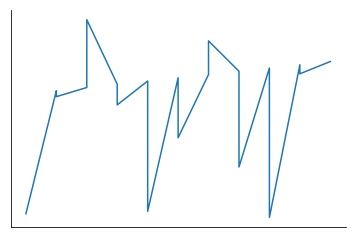

In [165]:
plt.xkcd()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xticks([])
plt.yticks([])
plt.plot(data.time, data.value)